<a href="https://colab.research.google.com/github/Byeon-MJ/Computer_Vision_Project/blob/main/Diagnose_Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# tensorflow 버전 확인
import tensorflow as tf
tf.__version__

'2.9.2'

# 데이터셋 다운로드

In [3]:
# Kaggle API 설치
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# kaggle.json 파일 VM에 업로드
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mjbyeon","key":"53ea0c00f9c398afd45229ed1ac4779e"}'}

In [5]:
!ls -1ha kaggle.json

kaggle.json


In [6]:
# Kaggle API Token 사용위해 kaggle.json 파일 이동
!mkdir -p ~/.kaggle

In [7]:
!mv kaggle.json ~/.kaggle/

In [8]:
# Permission Warning 방지, 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# kaggle datasets 다운로드
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:46<00:00, 24.0MB/s]
100% 2.29G/2.29G [01:46<00:00, 23.1MB/s]


In [10]:
# 다운받은 zip 압축 해제
from zipfile import ZipFile

with ZipFile('chest-xray-pneumonia.zip') as z:
    z.extractall()

In [11]:
# >> 저장 공간 부족으로 드라이브 이동 x
# # 다운받은 dataset 구글 드라이브로 이동
# !mv chest_xray /content/gdrive/MyDrive/CV/Diagnose\ Pneumonia/

In [12]:
# 다운로드 받았던 zip 파일 제거
!rm chest-xray-pneumonia.zip

In [13]:
# dataset 확인
!ls /content/chest_xray/chest_xray/test

NORMAL	PNEUMONIA


# 모델 학습 및 예측

## Modules import

In [14]:
# 모듈 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
# 데이터 가져오기
root = 'chest_xray/'
file_path1 = 'chest_xray/train/NORMAL/'
total_images_train_normal = os.listdir(root + file_path1)
file_path2 = 'chest_xray/train/PNEUMONIA/'
total_images_train_pneumonia = os.listdir(root + file_path2)

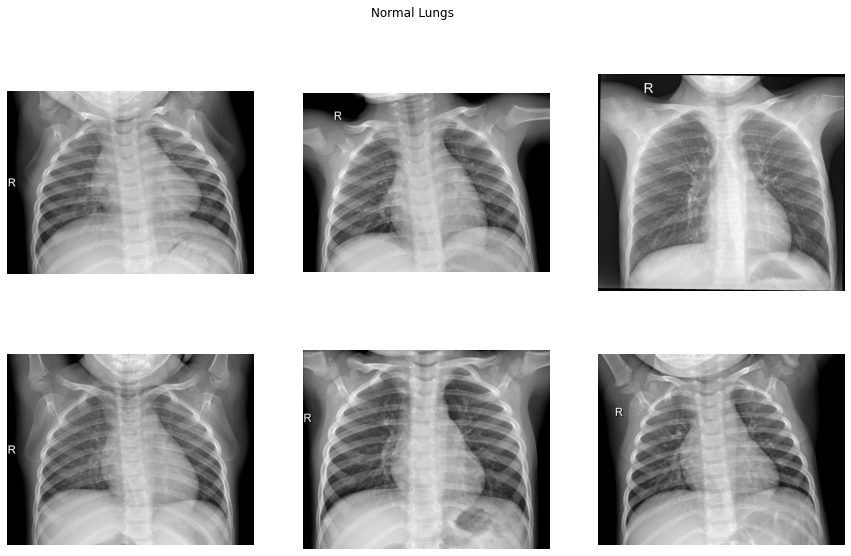

In [16]:
# Normal Sample Data
sample_normal = random.sample(total_images_train_normal,6)
f, ax = plt.subplots(2, 3, figsize = (15, 9))

for i in range(0, 6):
    im = cv2.imread(root + file_path1 + sample_normal[i])
    ax[i//3, i%3].imshow(im)
    ax[i//3, i%3].axis('off')
    
f.suptitle('Normal Lungs')
plt.show()

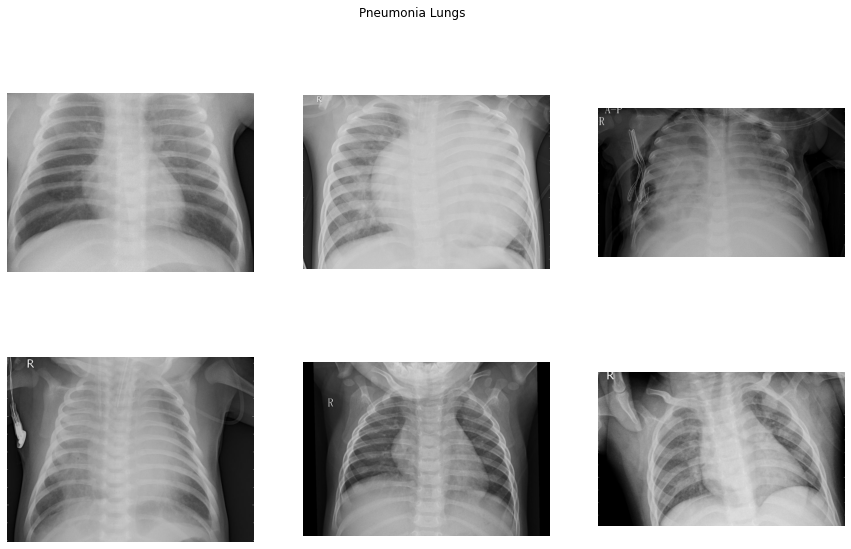

In [17]:
# PNEUMONIA Sample Data
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f, ax = plt.subplots(2, 3, figsize = (15, 9))

for i in range(0, 6):
    im = cv2.imread(root + file_path2 + sample_pneumonia[i])
    ax[i//3, i%3].imshow(im)
    ax[i//3, i%3].axis('off')
    
f.suptitle('Pneumonia Lungs')
plt.show()

In [18]:
# 필요한 상수 정의
image_height = 150  # 이미지 높이
image_width = 150   # 이미지 넓이
batch_size = 10     # batch size
no_of_epochs = 30   # training 횟수

In [19]:
# 모델 생성
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(image_height, image_width, 3), activation='relu'))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

In [20]:
# ImageDataGenerator 인스턴트 생성
train_datagen = ImageDataGenerator(rescale = 1./255,        # 픽셀 값을 0 ~ 1 범위로 변환
                                   rotation_range = 15,     # 15도까지 회전
                                   shear_range = 0.2,       # 20%까지 기울임
                                   zoom_range = 0.2         # 20%까지 확대
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
# train_datagen 인스턴스로 training_set 객체 생성
training_set = train_datagen.flow_from_directory('chest_xray/chest_xray/train',
                                                 target_size = (image_width, image_height),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

# val_datagen 인스턴스로 test_set 객체 생성
test_set = val_datagen.flow_from_directory('chest_xray/chest_xray/test',
                                           target_size = (image_width, image_height),
                                           batch_size = batch_size,
                                           class_mode = 'binary')

# val_datagen 인스턴스로 val_set 객체 생성
val_set = val_datagen.flow_from_directory('chest_xray/chest_xray/val',
                                          target_size = (image_width, image_height),
                                          batch_size = 1,
                                          shuffle = False,
                                          class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [22]:
# 모델 학습시 최고 모델을 저장하는 옵션 정의
modelCheckpoint = ModelCheckpoint('diagnose_pneumonia_model.h5', save_best_only=True)

# 조기 학습 종료 옵션 정의
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

In [23]:
# 모델 학습
history = model.fit_generator(training_set,
                              steps_per_epoch = 5216//batch_size,               # train_data 이미지 수
                              epochs = no_of_epochs,
                              validation_data = test_set,
                              validation_steps = 624//batch_size,               # test_dataseet 이미지 수
                              callbacks = [monitor_val_acc, modelCheckpoint])

<ipython-input-23-d346c5388c4f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_set,


Epoch 1/30
521/521 [==============================] - 95s 165ms/step - loss: 0.4769 - accuracy: 0.7939 - val_loss: 0.3354 - val_accuracy: 0.8710
Epoch 2/30
521/521 [==============================] - 82s 158ms/step - loss: 0.2831 - accuracy: 0.8828 - val_loss: 0.5475 - val_accuracy: 0.8177
Epoch 3/30
521/521 [==============================] - 89s 171ms/step - loss: 0.2598 - accuracy: 0.8986 - val_loss: 0.3489 - val_accuracy: 0.8581
Epoch 4/30
521/521 [==============================] - 83s 160ms/step - loss: 0.2386 - accuracy: 0.9051 - val_loss: 0.2927 - val_accuracy: 0.8758
Epoch 5/30
521/521 [==============================] - 84s 162ms/step - loss: 0.2199 - accuracy: 0.9090 - val_loss: 0.2456 - val_accuracy: 0.8871
Epoch 6/30
521/521 [==============================] - 86s 164ms/step - loss: 0.2026 - accuracy: 0.9245 - val_loss: 0.3138 - val_accuracy: 0.8500
Epoch 7/30
521/521 [==============================] - 84s 161ms/step - loss: 0.1924 - accuracy: 0.9211 - val_loss: 0.2404 - val_ac

In [24]:
# model evaluate
score = model.evaluate(test_set, steps=624//batch_size, verbose=1)
print('Val loss:', score[0])
print('Val accuracy:', score[1]*100)

62/62 [==============================] - 5s 87ms/step - loss: 0.3095 - accuracy: 0.9016
Val loss: 0.3094841241836548
Val accuracy: 90.16128778457642


In [25]:
# test_set 이미지 클래스 인덱스 확인
print(test_set.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


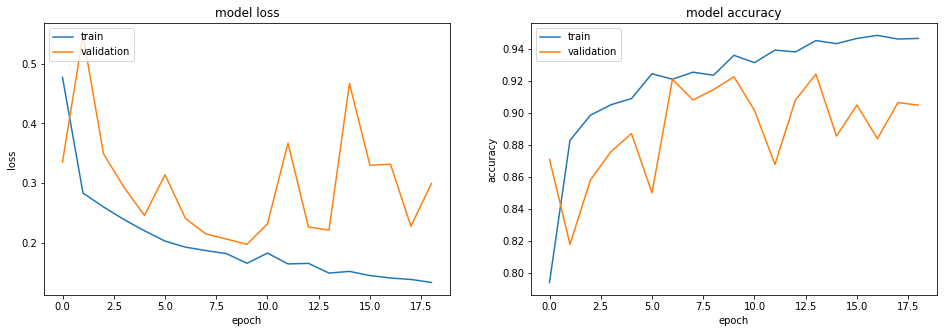

In [26]:
# loss graph
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [27]:
# 분류 예측
predictions = model.predict(val_set, steps = 16, verbose = 1)

16/16 [==============================] - 0s 10ms/step


In [28]:
# val_set 이미지 클래스 인덱스 확인
print(val_set.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


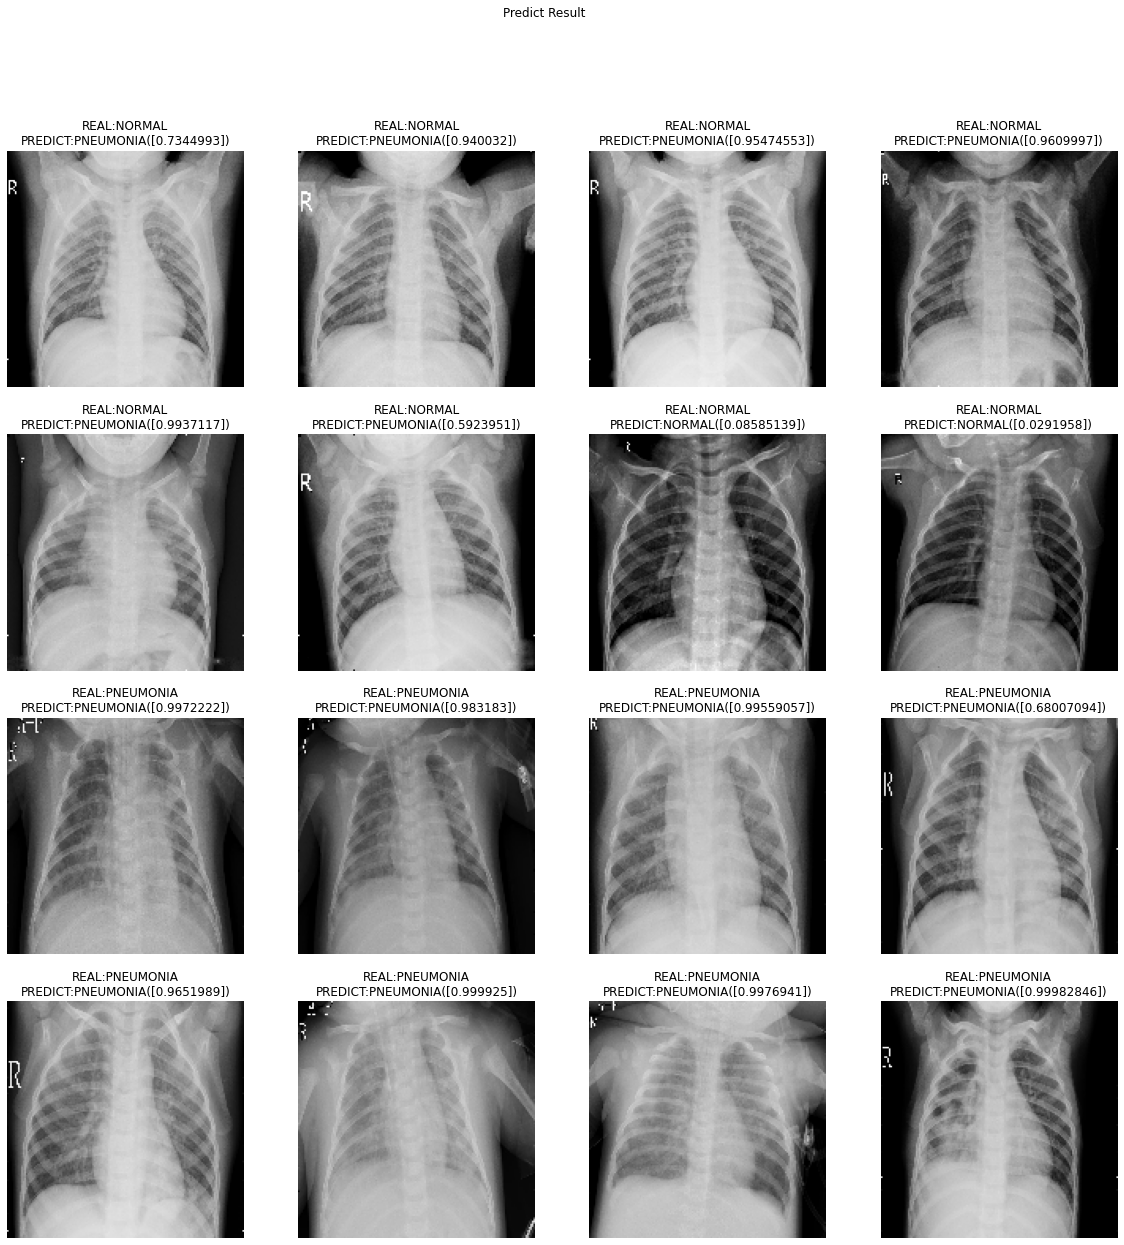

In [29]:
# 예측 결과 확인
f, ax = plt.subplots(4, 4, figsize = (20, 20))

for i in range(len(predictions)):
    # val_set이 만들어 낸 이미지를 하나씩 꺼내온다.
    image, label = val_set.next()
    # val_set이 만들어 낸 이미지의 label name을 가져옴
    real_class = 'NORMAL' if int(label) == 0 else 'PNEUMONIA'
    # val_set이 만들어 낸 이미지를 보여줌
    ax[i//4, i%4].imshow(image[0])
    ax[i//4, i%4].axis('off')

    # val_set이 만들어 낸 이미지를 모델을 통해 예측한 결과 값의 label name
    pred_class = 'PNEUMONIA' if predictions[i] > 0.5 else 'NORMAL'
    # val_set이 만들어 낸 이미지를 모델을 통해 예측한 결과(확률값)
    pred_prob = predictions[i]
    # title에 실제값과 모델에 의해 예측된 예측값을 함께 보여준다.
    ax[i//4, i%4].set_title('REAL:' + real_class + '\nPREDICT:' + pred_class + '(' + str(pred_prob) + ')')

f.suptitle('Predict Result')

plt.show()